In [51]:
import numpy as np
import matplotlib.pyplot as plt
import data
from data import DURATION, WIDTH, HEIGHT
import GPy


In [47]:
input_field_names = ["psl", "uas", "vas", "sfcWind"]
d = len(input_field_names)
input_fields = [data.load_field(name)[1] for name in input_field_names]
all_inputs = np.stack([f.values for f in input_fields], axis=4)
all_inputs = all_inputs.reshape(DURATION, HEIGHT, WIDTH, d)

_, wsgsmax_field = data.load_field("wsgsmax")
all_wsgsmax = wsgsmax_field.values.reshape(DURATION, HEIGHT, WIDTH)

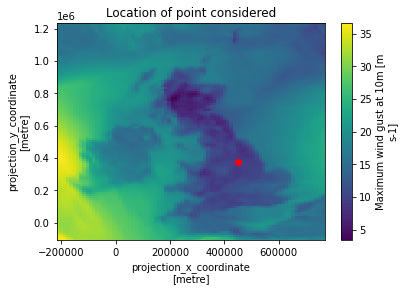

In [55]:
train_start = 500
train_length = 720
test_length = 360
train_time = np.arange(train_start, train_start + train_length, 1)
test_time = np.arange(train_start + train_length, train_start + train_length + test_length, 1)
x = 55
y = 40

train_inputs = all_inputs[train_time, y, x, :]
train_wsgsmax = all_wsgsmax[train_time, y, x]
test_inputs = all_inputs[test_time, y, x, :]
test_wsgsmax = all_wsgsmax[test_time, y, x]

wsgsmax_field[0,0].plot()
plt.title("Location of point considered")
plt.scatter([wsgsmax_field.projection_x_coordinate[x]], [wsgsmax_field.projection_y_coordinate[y]], color="red")
plt.show()

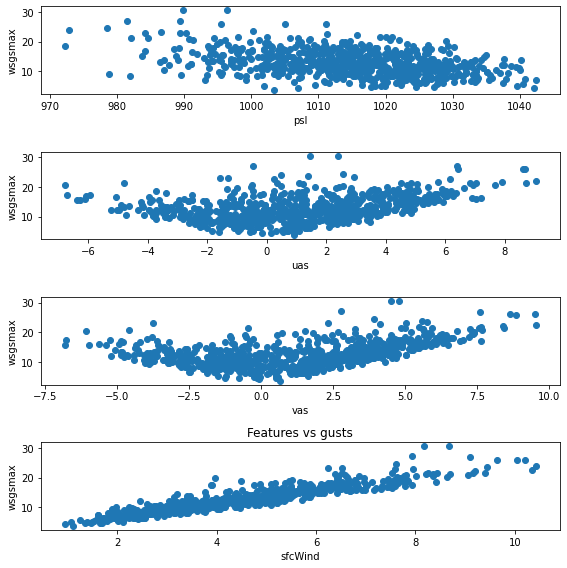

In [56]:
fig, axes = plt.subplots(len(input_field_names), figsize=(8,8))
for i, (name, ax) in enumerate(zip(input_field_names, axes)):
    ax.scatter(train_inputs[:, i], train_wsgsmax)
    ax.set_ylabel("wsgsmax")
    ax.set_xlabel(name)
plt.title("Features vs gusts")
plt.tight_layout()
plt.show()

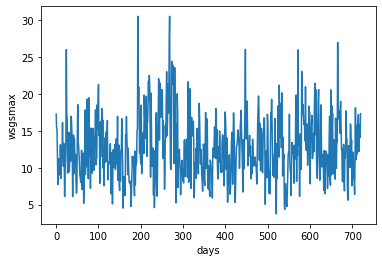

In [46]:
plt.plot(range(train_wsgsmax.shape[0]), train_wsgsmax)
plt.xlabel("days")
plt.ylabel("wsgsmax")
plt.show()

In [58]:
kernels = [
    GPy.kern.Linear(input_dim=1, active_dims=[0]),
    GPy.kern.RBF(input_dim=1, active_dims=[1]),
    GPy.kern.RBF(input_dim=1, active_dims=[2]),
    GPy.kern.Linear(input_dim=1, active_dims=[3]),
]
kernel = kernels[0] * kernels[1] * kernels[2] * kernels[3]
m = GPy.models.GPRegression(inputs, wsgsmax.reshape(-1, 1), kernel)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0001   2.863626e+03   6.257742e+05 
    00s15  0002   2.280815e+03   1.665983e+05 
    01s01  0020   1.377434e+03   3.693112e-08 
Runtime:     01s01
Optimization status: Converged



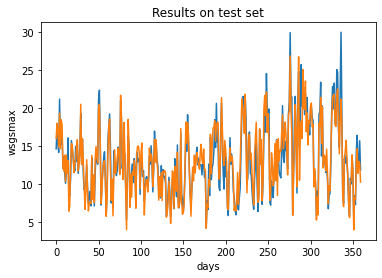

In [65]:
plt.plot(range(test_wsgsmax.shape[0]), test_wsgsmax, color="C0")
preds = m.predict(test_inputs)
plt.plot(range(test_wsgsmax.shape[0]), preds[0].reshape(-1), color="C1")
plt.xlabel("days")
plt.ylabel("wsgsmax")
plt.title("Results on test set")
plt.show()